# Exploratory Data Analysis (EDA)
## Credit Risk Probability Model - Alternative Data

This notebook contains exploratory analysis of the eCommerce transaction data to understand patterns, identify data quality issues, and form hypotheses for feature engineering.

**Note**: This notebook is for exploration only, not for production code.


## 1. Import Libraries and Set Up Environment


In [1]:
# Standard library imports
import os
import warnings
from pathlib import Path

# Data manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
try:
    import plotly.express as px
    import plotly.graph_objects as go
    from plotly.subplots import make_subplots
    PLOTLY_AVAILABLE = True
except ImportError:
    PLOTLY_AVAILABLE = False
    print("Note: Plotly not available, some interactive plots will be skipped")

# Statistical analysis
from scipy import stats
from scipy.stats import skew, kurtosis

# Configuration
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Set style for plots - try different style names for compatibility
try:
    plt.style.use('seaborn-v0_8-darkgrid')
except OSError:
    try:
        plt.style.use('seaborn-darkgrid')
    except OSError:
        plt.style.use('dark_background')
        print("Note: Using default dark_background style")

sns.set_palette("husl")

# Set random seed for reproducibility
np.random.seed(42)

print("Libraries imported successfully!")
print(f"Pandas version: {pd.__version__}")
print(f"NumPy version: {np.__version__}")
print(f"Matplotlib version: {plt.matplotlib.__version__}")
print(f"Seaborn version: {sns.__version__}")


Libraries imported successfully!
Pandas version: 2.3.3
NumPy version: 2.3.5
Matplotlib version: 3.10.8
Seaborn version: 0.13.2


## 2. Load Data


In [2]:
# Define data paths
project_root = Path().resolve().parent
data_raw_path = project_root / 'data' / 'raw'

# Check if data directory exists
if not data_raw_path.exists():
    print(f"Data directory not found at {data_raw_path}")
    print("Please ensure the data files are placed in the data/raw/ directory")
else:
    # List available files
    data_files = list(data_raw_path.glob('*.csv'))
    print(f"Found {len(data_files)} CSV file(s) in data/raw/")
    for file in data_files:
        print(f"  - {file.name}")

# Load the main transaction data
# Note: Update the filename based on actual data file name
try:
    # Try common file names
    possible_names = ['transactions.csv', 'train.csv', 'data.csv', 'xente.csv']
    data_file = None
    
    for name in possible_names:
        file_path = data_raw_path / name
        if file_path.exists():
            data_file = file_path
            break
    
    if data_file:
        print(f"\nLoading data from: {data_file.name}")
        df = pd.read_csv(data_file, low_memory=False)
        print(f"Data loaded successfully!")
    else:
        print("\nNo data file found. Creating sample structure for demonstration...")
        # Create a sample dataframe structure for demonstration
        df = pd.DataFrame({
            'TransactionId': [],
            'BatchId': [],
            'AccountId': [],
            'SubscriptionId': [],
            'CustomerId': [],
            'CurrencyCode': [],
            'CountryCode': [],
            'ProviderId': [],
            'ProductId': [],
            'ProductCategory': [],
            'ChannelId': [],
            'Amount': [],
            'Value': [],
            'TransactionStartTime': [],
            'PricingStrategy': [],
            'FraudResult': []
        })
        print("Sample structure created. Please load actual data when available.")
except Exception as e:
    print(f"Error loading data: {e}")
    df = pd.DataFrame()


Found 2 CSV file(s) in data/raw/
  - Xente_Variable_Definitions.csv
  - data.csv

Loading data from: data.csv
Data loaded successfully!


## 3. Overview of the Data


In [3]:
print("=" * 80)
print("DATA OVERVIEW")
print("=" * 80)

if df.empty:
    print("DataFrame is empty. Please load the data first.")
else:
    # Basic information
    print(f"\nDataset Shape: {df.shape[0]:,} rows × {df.shape[1]} columns")
    print(f"\nMemory Usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
    
    # Display first few rows
    print("\n" + "=" * 80)
    print("First 5 Rows:")
    print("=" * 80)
    display(df.head())
    
    # Data types
    print("\n" + "=" * 80)
    print("Data Types:")
    print("=" * 80)
    dtype_info = pd.DataFrame({
        'Column': df.dtypes.index,
        'Data Type': df.dtypes.values,
        'Non-Null Count': df.count().values,
        'Null Count': df.isnull().sum().values
    })
    display(dtype_info)
    
    # Column names
    print("\n" + "=" * 80)
    print("Column Names:")
    print("=" * 80)
    for i, col in enumerate(df.columns, 1):
        print(f"{i:2d}. {col}")


DATA OVERVIEW

Dataset Shape: 95,662 rows × 16 columns

Memory Usage: 66.48 MB

First 5 Rows:


,TransactionId,BatchId,AccountId,SubscriptionId,CustomerId,CurrencyCode,CountryCode,ProviderId,ProductId,ProductCategory,ChannelId,Amount,Value,TransactionStartTime,PricingStrategy,FraudResult
0,TransactionId_76871,BatchId_36123,AccountId_3957,SubscriptionId_887,CustomerId_4406,UGX,256,ProviderId_6,ProductId_10,airtime,ChannelId_3,1000.000,1000,2018-11-15T02:18:49Z,2,0
1,TransactionId_73770,BatchId_15642,AccountId_4841,SubscriptionId_3829,CustomerId_4406,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-20.000,20,2018-11-15T02:19:08Z,2,0
2,TransactionId_26203,BatchId_53941,AccountId_4229,SubscriptionId_222,CustomerId_4683,UGX,256,ProviderId_6,ProductId_1,airtime,ChannelId_3,500.000,500,2018-11-15T02:44:21Z,2,0
3,TransactionId_380,BatchId_102363,AccountId_648,SubscriptionId_2185,CustomerId_988,UGX,256,ProviderId_1,ProductId_21,utility_bill,ChannelId_3,20000.000,21800,2018-11-15T03:32:55Z,2,0
4,TransactionId_28195,BatchId_38780,AccountId_4841,SubscriptionId_3829,CustomerId_988,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-644.000,644,2018-11-15T03:34:21Z,2,0



Data Types:


,Column,Data Type,Non-Null Count,Null Count
0,TransactionId,object,95662,0
1,BatchId,object,95662,0
2,AccountId,object,95662,0
3,SubscriptionId,object,95662,0
4,CustomerId,object,95662,0
5,CurrencyCode,object,95662,0
6,CountryCode,int64,95662,0
7,ProviderId,object,95662,0
8,ProductId,object,95662,0
9,ProductCategory,object,95662,0



Column Names:
 1. TransactionId
 2. BatchId
 3. AccountId
 4. SubscriptionId
 5. CustomerId
 6. CurrencyCode
 7. CountryCode
 8. ProviderId
 9. ProductId
10. ProductCategory
11. ChannelId
12. Amount
13. Value
14. TransactionStartTime
15. PricingStrategy
16. FraudResult


## 4. Summary Statistics


In [4]:
if not df.empty:
    print("=" * 80)
    print("SUMMARY STATISTICS - NUMERICAL FEATURES")
    print("=" * 80)
    
    # Identify numerical columns
    numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    
    if numerical_cols:
        print(f"\nNumerical columns ({len(numerical_cols)}): {', '.join(numerical_cols)}")
        display(df[numerical_cols].describe())
        
        # Additional statistics
        print("\n" + "=" * 80)
        print("ADDITIONAL STATISTICS")
        print("=" * 80)
        
        additional_stats = pd.DataFrame({
            'Column': numerical_cols,
            'Skewness': [skew(df[col].dropna()) for col in numerical_cols],
            'Kurtosis': [kurtosis(df[col].dropna()) for col in numerical_cols],
            'Min': [df[col].min() for col in numerical_cols],
            'Max': [df[col].max() for col in numerical_cols],
            'Range': [df[col].max() - df[col].min() for col in numerical_cols],
            'IQR': [df[col].quantile(0.75) - df[col].quantile(0.25) for col in numerical_cols]
        })
        display(additional_stats)
    else:
        print("No numerical columns found.")
    
    print("\n" + "=" * 80)
    print("SUMMARY STATISTICS - CATEGORICAL FEATURES")
    print("=" * 80)
    
    # Identify categorical columns
    categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
    
    if categorical_cols:
        print(f"\nCategorical columns ({len(categorical_cols)}): {', '.join(categorical_cols)}")
        for col in categorical_cols:
            print(f"\n{col}:")
            print(f"  Unique values: {df[col].nunique()}")
            print(f"  Most frequent:")
            display(df[col].value_counts().head(10))
    else:
        print("No categorical columns found.")


SUMMARY STATISTICS - NUMERICAL FEATURES

Numerical columns (5): CountryCode, Amount, Value, PricingStrategy, FraudResult


,CountryCode,Amount,Value,PricingStrategy,FraudResult
count,95662.000,95662.000,95662.000,95662.000,95662.000
mean,256.000,6717.846,9900.584,2.256,0.002
std,0.000,123306.797,123122.088,0.733,0.045
min,256.000,-1000000.000,2.000,0.000,0.000
25%,256.000,-50.000,275.000,2.000,0.000
50%,256.000,1000.000,1000.000,2.000,0.000
75%,256.000,2800.000,5000.000,2.000,0.000
max,256.000,9880000.000,9880000.000,4.000,1.000



ADDITIONAL STATISTICS


,Column,Skewness,Kurtosis,Min,Max,Range,IQR
0,CountryCode,NaN,NaN,256.000,256.000,0.000,0.000
1,Amount,51.098,3362.952,-1000000.000,9880000.000,10880000.000,2850.000
2,Value,51.290,3377.893,2.000,9880000.000,9879998.000,4725.000
3,PricingStrategy,1.659,2.087,0.000,4.000,4.000,0.000
4,FraudResult,22.196,490.660,0.000,1.000,1.000,0.000



SUMMARY STATISTICS - CATEGORICAL FEATURES

Categorical columns (11): TransactionId, BatchId, AccountId, SubscriptionId, CustomerId, CurrencyCode, ProviderId, ProductId, ProductCategory, ChannelId, TransactionStartTime

TransactionId:
  Unique values: 95662
  Most frequent:


TransactionId
TransactionId_76871     1
TransactionId_74922     1
TransactionId_2737      1
TransactionId_28101     1
TransactionId_33267     1
TransactionId_135291    1
TransactionId_87468     1
TransactionId_134872    1
TransactionId_113925    1
TransactionId_16554     1
Name: count, dtype: int64


BatchId:
  Unique values: 94809
  Most frequent:


BatchId
BatchId_67019     28
BatchId_51870     16
BatchId_113893    14
BatchId_127204    12
BatchId_116835    10
BatchId_88001      9
BatchId_49408      7
BatchId_110084     7
BatchId_86880      6
BatchId_107049     6
Name: count, dtype: int64


AccountId:
  Unique values: 3633
  Most frequent:


AccountId
AccountId_4841    30893
AccountId_4249     4457
AccountId_4840     1738
AccountId_3206     1105
AccountId_318      1070
AccountId_10        965
AccountId_3595      465
AccountId_751       411
AccountId_2648      359
AccountId_2314      356
Name: count, dtype: int64


SubscriptionId:
  Unique values: 3627
  Most frequent:


SubscriptionId
SubscriptionId_3829    32630
SubscriptionId_4429     4457
SubscriptionId_1372     1105
SubscriptionId_3087     1070
SubscriptionId_4346      965
SubscriptionId_1749      465
SubscriptionId_919       411
SubscriptionId_1311      359
SubscriptionId_4722      356
SubscriptionId_652       350
Name: count, dtype: int64


CustomerId:
  Unique values: 3742
  Most frequent:


CustomerId
CustomerId_7343    4091
CustomerId_3634    2085
CustomerId_647     1869
CustomerId_1096     784
CustomerId_4033     778
CustomerId_3066     612
CustomerId_2528     610
CustomerId_2728     586
CustomerId_3078     573
CustomerId_806      557
Name: count, dtype: int64


CurrencyCode:
  Unique values: 1
  Most frequent:


CurrencyCode
UGX    95662
Name: count, dtype: int64


ProviderId:
  Unique values: 6
  Most frequent:


ProviderId
ProviderId_4    38189
ProviderId_6    34186
ProviderId_5    14542
ProviderId_1     5643
ProviderId_3     3084
ProviderId_2       18
Name: count, dtype: int64


ProductId:
  Unique values: 23
  Most frequent:


ProductId
ProductId_6     32635
ProductId_3     24344
ProductId_10    15384
ProductId_15    11964
ProductId_1      2885
ProductId_4      2403
ProductId_21     1512
ProductId_11     1377
ProductId_19      965
ProductId_14      789
Name: count, dtype: int64


ProductCategory:
  Unique values: 9
  Most frequent:


ProductCategory
financial_services    45405
airtime               45027
utility_bill           1920
data_bundles           1613
tv                     1279
ticket                  216
movies                  175
transport                25
other                     2
Name: count, dtype: int64


ChannelId:
  Unique values: 4
  Most frequent:


ChannelId
ChannelId_3    56935
ChannelId_2    37141
ChannelId_5     1048
ChannelId_1      538
Name: count, dtype: int64


TransactionStartTime:
  Unique values: 94556
  Most frequent:


TransactionStartTime
2018-12-24T16:30:13Z    17
2018-11-15T07:03:26Z     9
2018-12-24T16:30:12Z     6
2018-12-07T13:09:44Z     6
2018-11-15T07:03:27Z     5
2019-01-04T04:29:41Z     4
2018-12-24T16:30:11Z     4
2018-12-07T13:09:47Z     4
2018-12-07T11:54:01Z     4
2019-02-01T10:58:34Z     4
Name: count, dtype: int64

## 5. Distribution of Numerical Features


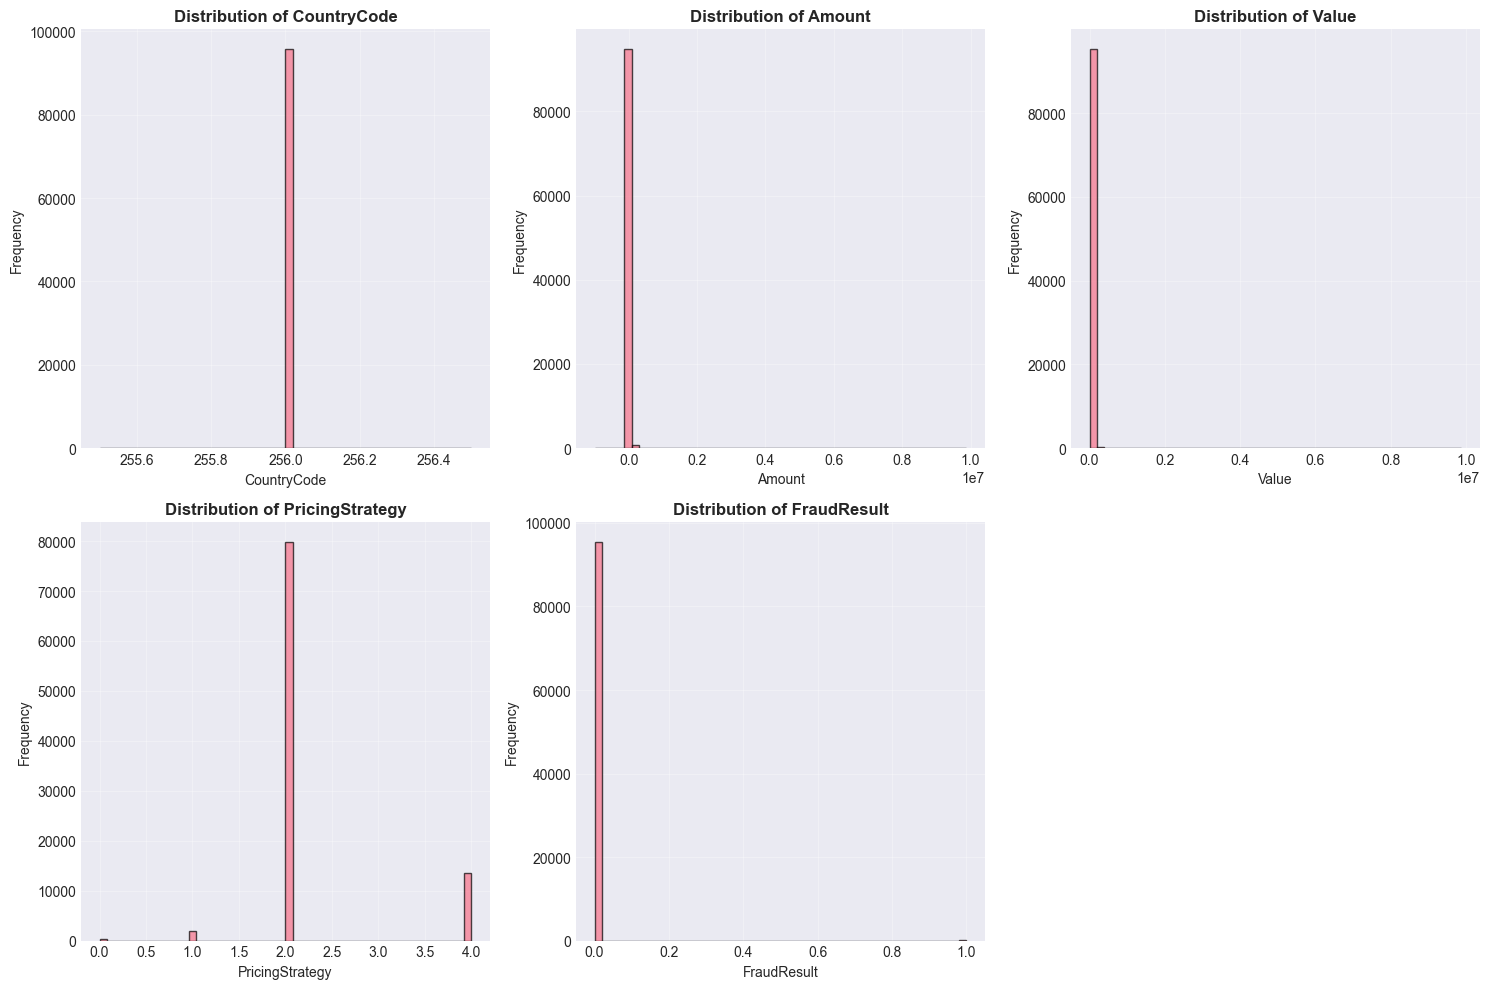


BOX PLOTS FOR OUTLIER DETECTION


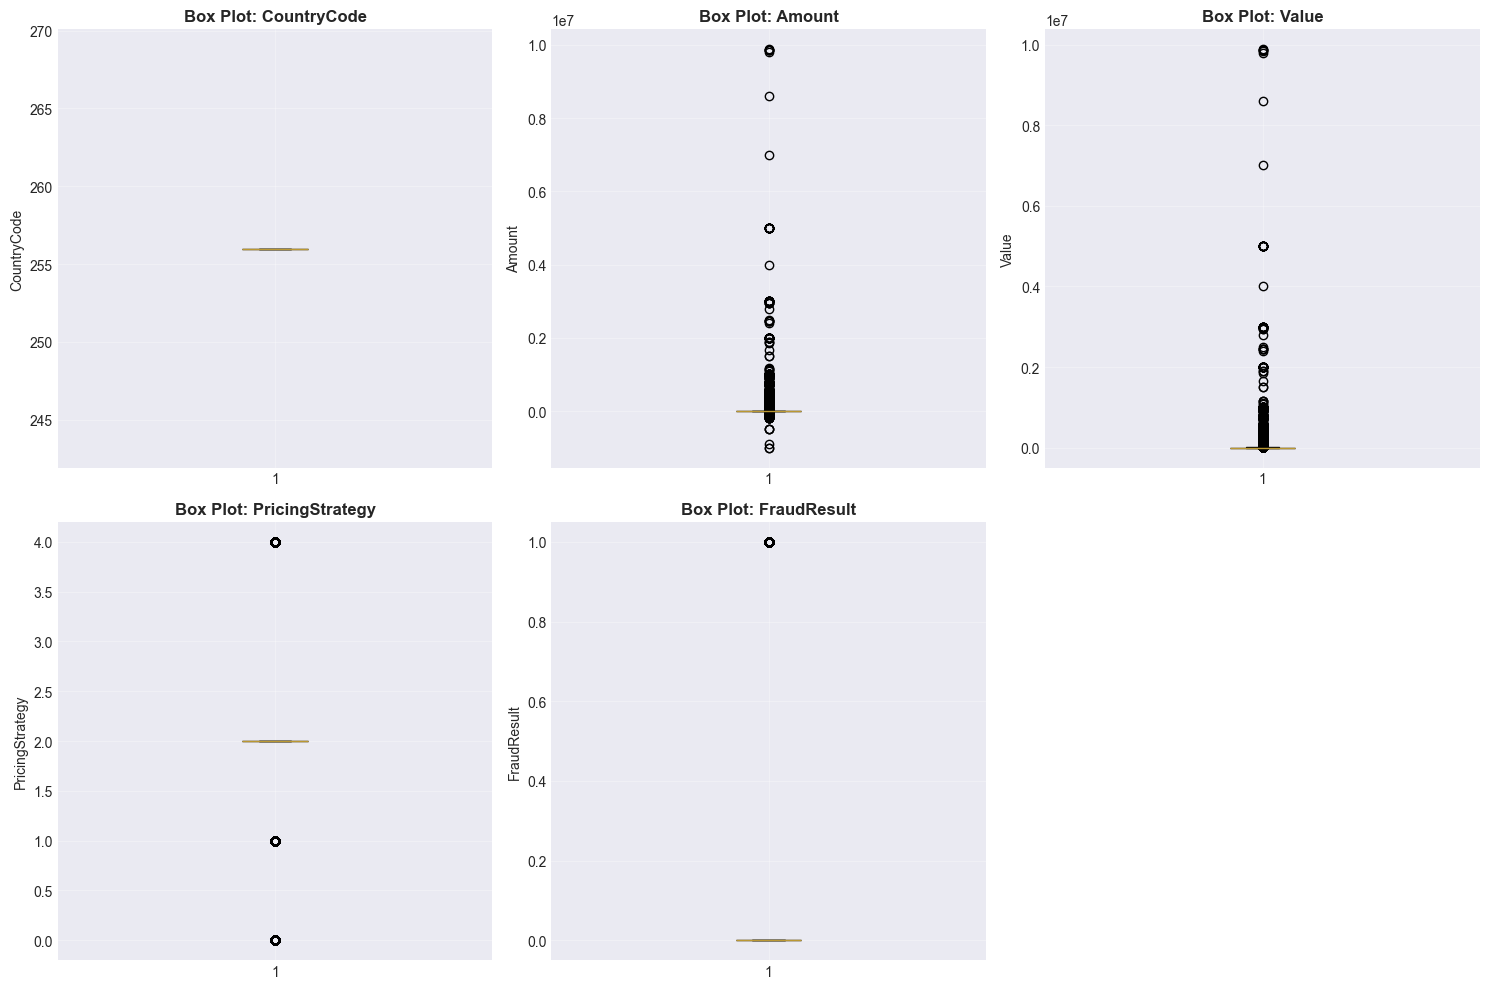

In [5]:
if not df.empty and 'numerical_cols' in locals() and numerical_cols:
    # Create distribution plots for numerical features
    n_cols = min(3, len(numerical_cols))
    n_rows = (len(numerical_cols) + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
    axes = axes.flatten() if n_rows > 1 else [axes] if n_cols == 1 else axes
    
    for idx, col in enumerate(numerical_cols):
        if idx < len(axes):
            ax = axes[idx]
            
            # Histogram with KDE
            df[col].dropna().hist(bins=50, ax=ax, alpha=0.7, edgecolor='black')
            ax.set_title(f'Distribution of {col}', fontsize=12, fontweight='bold')
            ax.set_xlabel(col, fontsize=10)
            ax.set_ylabel('Frequency', fontsize=10)
            ax.grid(True, alpha=0.3)
    
    # Hide extra subplots
    for idx in range(len(numerical_cols), len(axes)):
        axes[idx].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Box plots for outlier detection
    print("\n" + "=" * 80)
    print("BOX PLOTS FOR OUTLIER DETECTION")
    print("=" * 80)
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
    axes = axes.flatten() if n_rows > 1 else [axes] if n_cols == 1 else axes
    
    for idx, col in enumerate(numerical_cols):
        if idx < len(axes):
            ax = axes[idx]
            
            # Box plot
            bp = ax.boxplot(df[col].dropna(), vert=True, patch_artist=True)
            bp['boxes'][0].set_facecolor('lightblue')
            ax.set_title(f'Box Plot: {col}', fontsize=12, fontweight='bold')
            ax.set_ylabel(col, fontsize=10)
            ax.grid(True, alpha=0.3)
    
    # Hide extra subplots
    for idx in range(len(numerical_cols), len(axes)):
        axes[idx].axis('off')
    
    plt.tight_layout()
    plt.show()
else:
    print("No numerical columns available for visualization.")


## 6. Distribution of Categorical Features


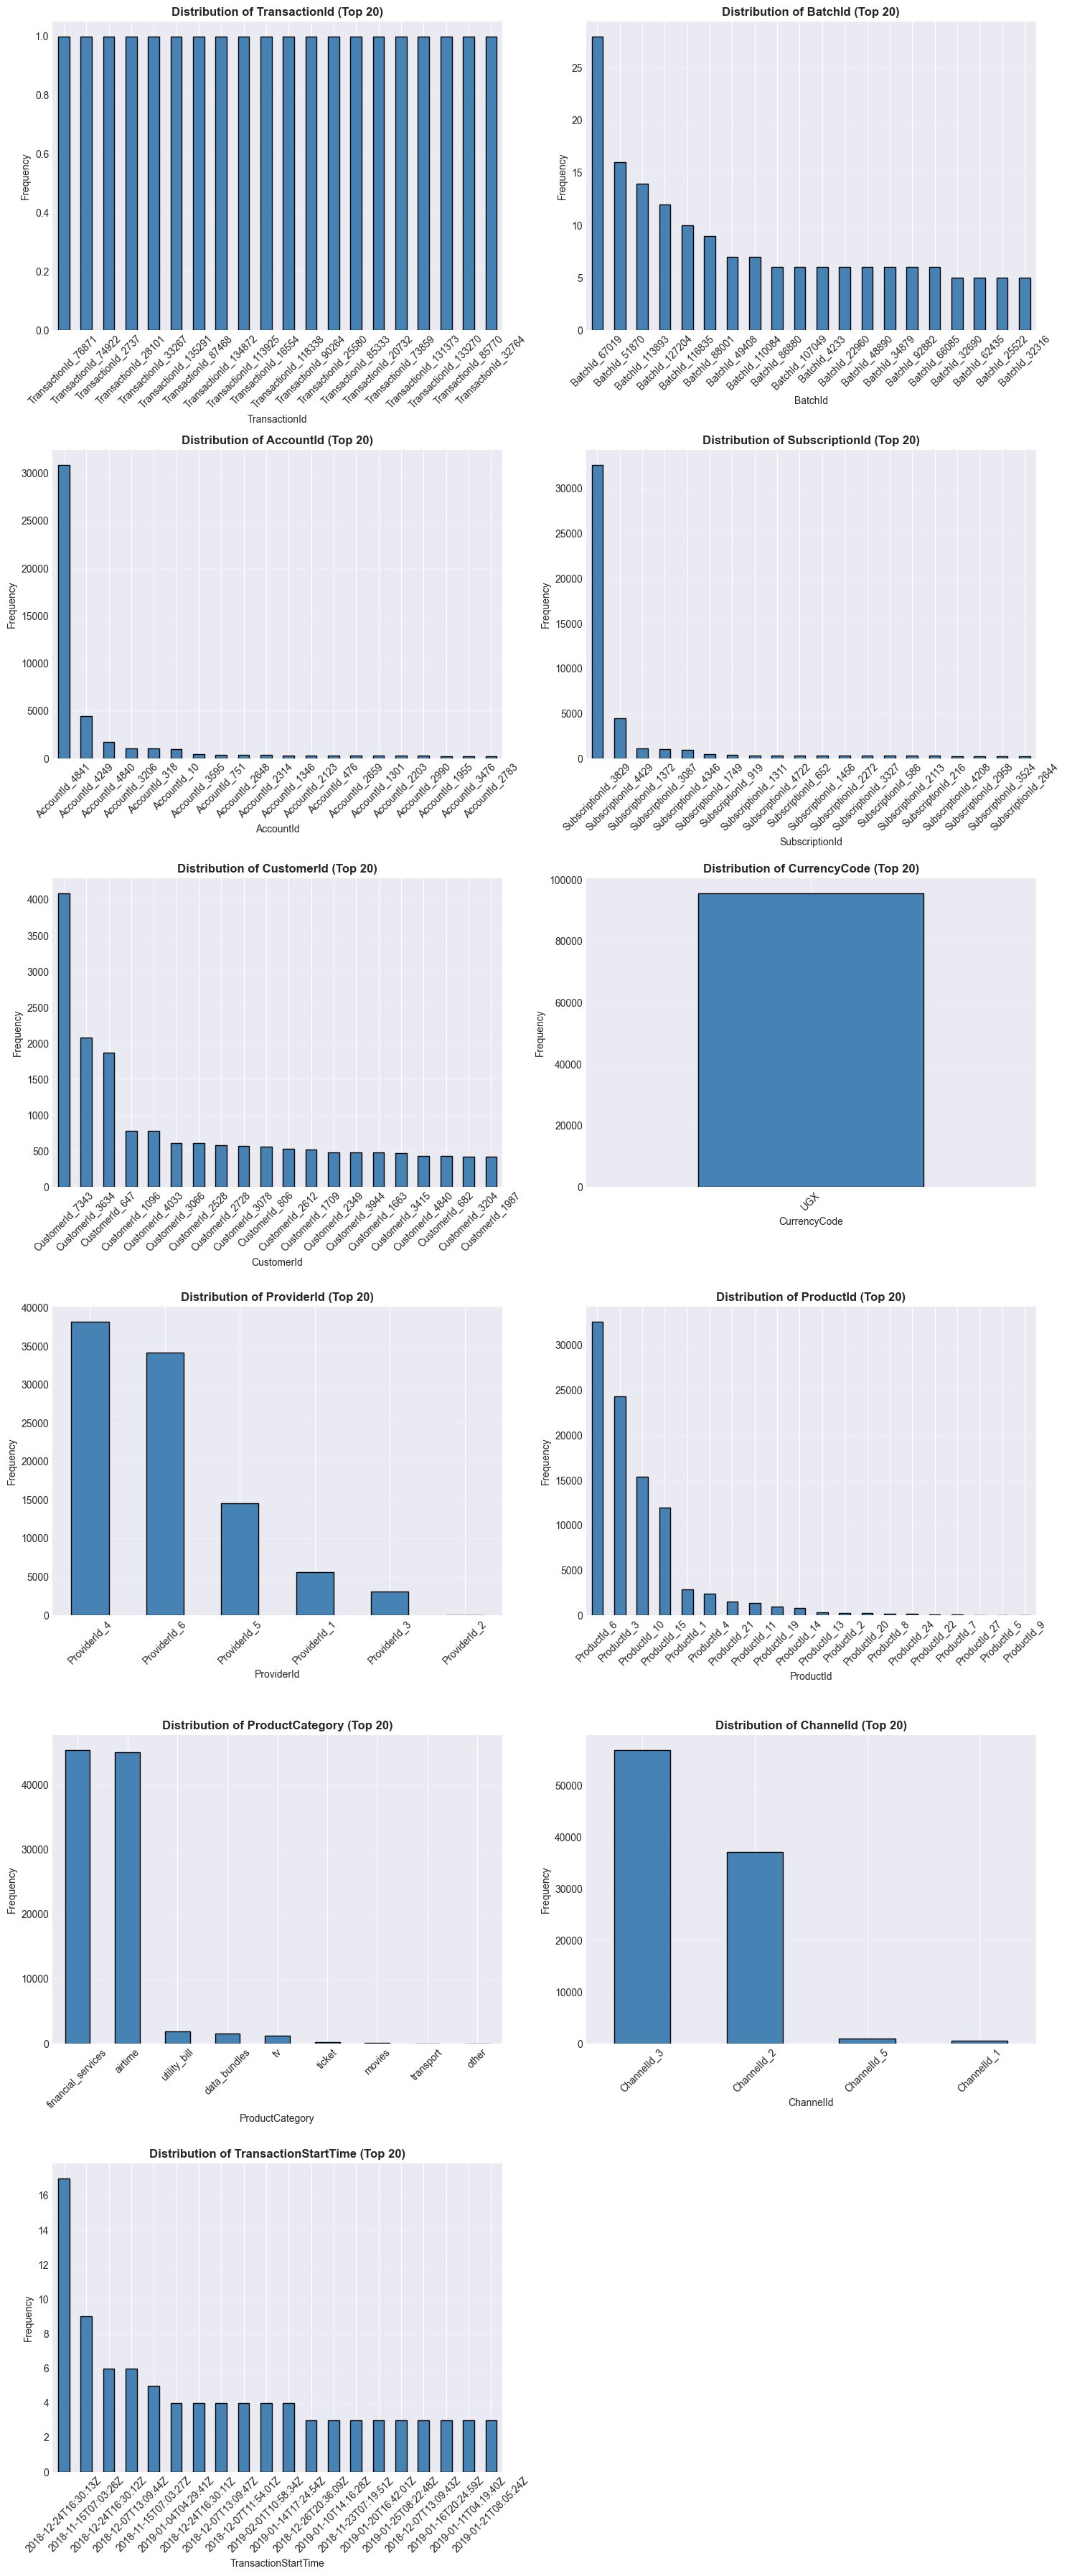


PIE CHARTS FOR KEY CATEGORICAL FEATURES


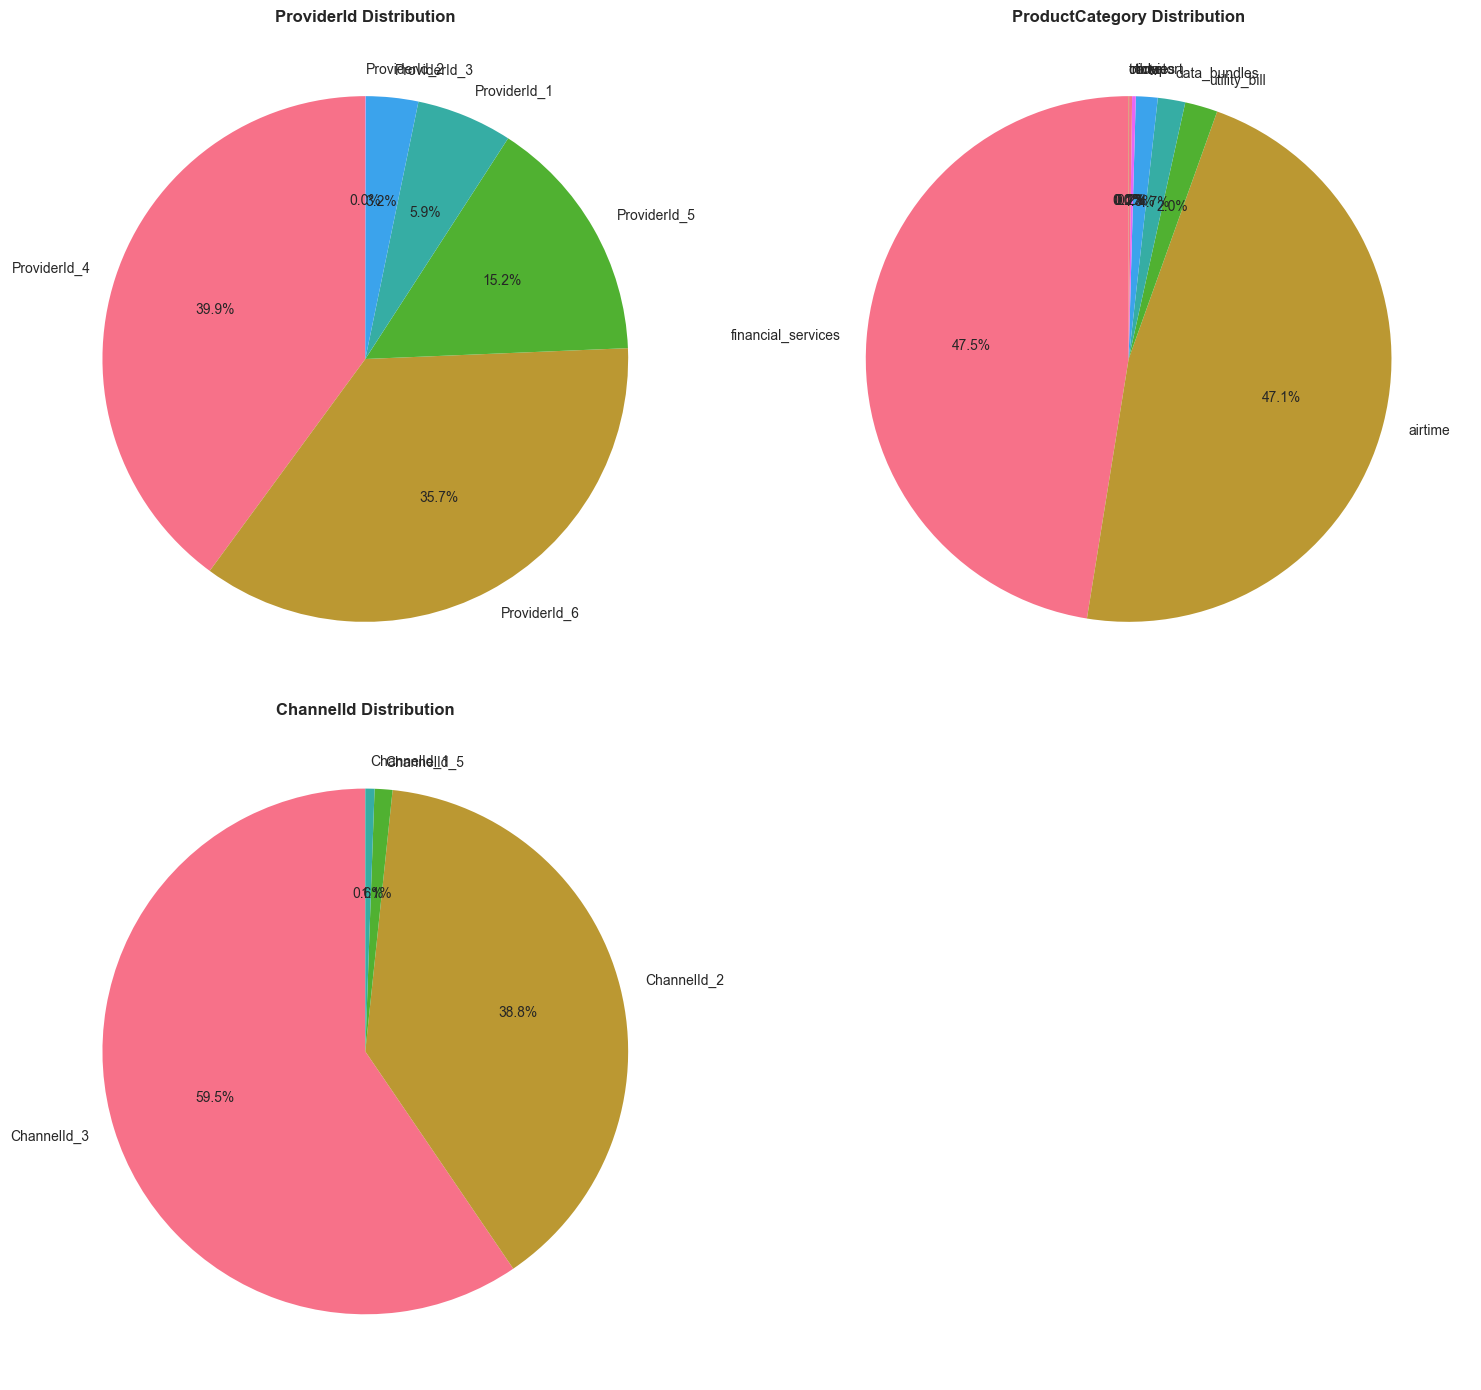

In [6]:
if not df.empty and 'categorical_cols' in locals() and categorical_cols:
    # Create bar plots for categorical features
    n_cols = min(2, len(categorical_cols))
    n_rows = (len(categorical_cols) + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 6 * n_rows))
    axes = axes.flatten() if n_rows > 1 else [axes] if n_cols == 1 else axes
    
    for idx, col in enumerate(categorical_cols):
        if idx < len(axes):
            ax = axes[idx]
            
            # Get top categories (limit to top 20 for readability)
            value_counts = df[col].value_counts().head(20)
            
            # Bar plot
            value_counts.plot(kind='bar', ax=ax, color='steelblue', edgecolor='black')
            ax.set_title(f'Distribution of {col} (Top 20)', fontsize=12, fontweight='bold')
            ax.set_xlabel(col, fontsize=10)
            ax.set_ylabel('Frequency', fontsize=10)
            ax.tick_params(axis='x', rotation=45)
            ax.grid(True, alpha=0.3, axis='y')
    
    # Hide extra subplots
    for idx in range(len(categorical_cols), len(axes)):
        axes[idx].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Pie charts for key categorical features (if reasonable number of categories)
    print("\n" + "=" * 80)
    print("PIE CHARTS FOR KEY CATEGORICAL FEATURES")
    print("=" * 80)
    
    # Select features with reasonable number of categories (2-10)
    pie_features = [col for col in categorical_cols if 2 <= df[col].nunique() <= 10]
    
    if pie_features:
        n_cols = min(2, len(pie_features))
        n_rows = (len(pie_features) + n_cols - 1) // n_cols
        
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 7 * n_rows))
        axes = axes.flatten() if n_rows > 1 else [axes] if n_cols == 1 else axes
        
        for idx, col in enumerate(pie_features):
            if idx < len(axes):
                ax = axes[idx]
                
                value_counts = df[col].value_counts()
                ax.pie(value_counts.values, labels=value_counts.index, autopct='%1.1f%%', startangle=90)
                ax.set_title(f'{col} Distribution', fontsize=12, fontweight='bold')
        
        # Hide extra subplots
        for idx in range(len(pie_features), len(axes)):
            axes[idx].axis('off')
        
        plt.tight_layout()
        plt.show()
else:
    print("No categorical columns available for visualization.")


## 7. Correlation Analysis


CORRELATION MATRIX


,CountryCode,Amount,Value,PricingStrategy,FraudResult
CountryCode,NaN,NaN,NaN,NaN,NaN
Amount,NaN,1.000,0.990,-0.062,0.557
Value,NaN,0.990,1.000,-0.017,0.567
PricingStrategy,NaN,-0.062,-0.017,1.000,-0.034
FraudResult,NaN,0.557,0.567,-0.034,1.000


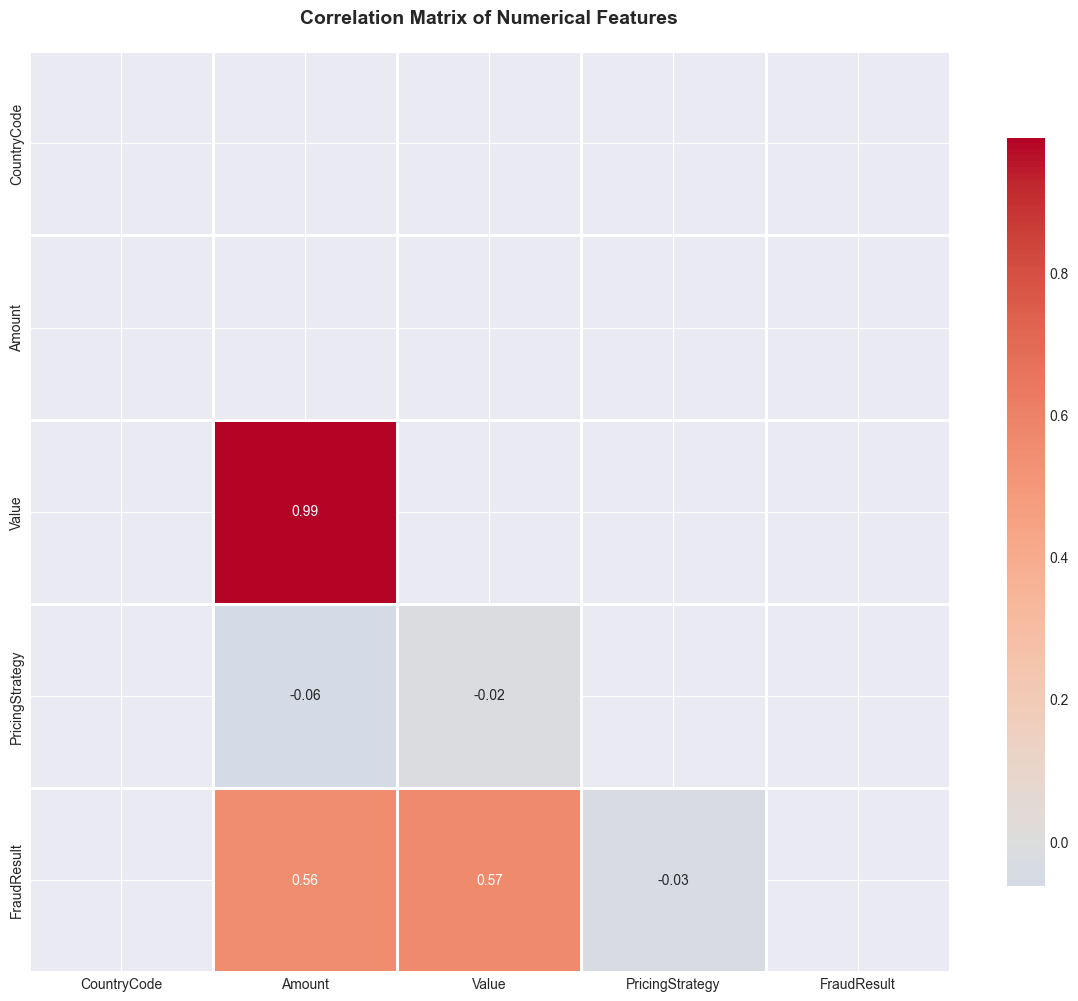


HIGH CORRELATIONS (|r| > 0.7)


,Feature 1,Feature 2,Correlation
0,Amount,Value,0.990


In [7]:
if not df.empty and 'numerical_cols' in locals() and len(numerical_cols) > 1:
    print("=" * 80)
    print("CORRELATION MATRIX")
    print("=" * 80)
    
    # Calculate correlation matrix
    corr_matrix = df[numerical_cols].corr()
    
    # Display correlation matrix
    display(corr_matrix)
    
    # Visualize correlation matrix as heatmap
    plt.figure(figsize=(12, 10))
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))  # Mask upper triangle
    sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.2f', cmap='coolwarm', 
                center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8})
    plt.title('Correlation Matrix of Numerical Features', fontsize=14, fontweight='bold', pad=20)
    plt.tight_layout()
    plt.show()
    
    # Identify high correlations (above threshold)
    print("\n" + "=" * 80)
    print("HIGH CORRELATIONS (|r| > 0.7)")
    print("=" * 80)
    
    high_corr_pairs = []
    for i in range(len(corr_matrix.columns)):
        for j in range(i+1, len(corr_matrix.columns)):
            corr_value = corr_matrix.iloc[i, j]
            if abs(corr_value) > 0.7:
                high_corr_pairs.append({
                    'Feature 1': corr_matrix.columns[i],
                    'Feature 2': corr_matrix.columns[j],
                    'Correlation': corr_value
                })
    
    if high_corr_pairs:
        high_corr_df = pd.DataFrame(high_corr_pairs)
        display(high_corr_df.sort_values('Correlation', key=abs, ascending=False))
    else:
        print("No high correlations found (|r| > 0.7)")
else:
    print("Insufficient numerical columns for correlation analysis.")


## 8. Identifying Missing Values


In [8]:
if not df.empty:
    print("=" * 80)
    print("MISSING VALUES ANALYSIS")
    print("=" * 80)
    
    # Calculate missing values
    missing_data = pd.DataFrame({
        'Column': df.columns,
        'Missing Count': df.isnull().sum().values,
        'Missing Percentage': (df.isnull().sum().values / len(df) * 100).round(2)
    })
    missing_data = missing_data[missing_data['Missing Count'] > 0].sort_values('Missing Count', ascending=False)
    
    if len(missing_data) > 0:
        print(f"\nColumns with missing values: {len(missing_data)}")
        display(missing_data)
        
        # Visualize missing values
        plt.figure(figsize=(12, 6))
        missing_data_sorted = missing_data.sort_values('Missing Percentage', ascending=True)
        plt.barh(missing_data_sorted['Column'], missing_data_sorted['Missing Percentage'], color='coral')
        plt.xlabel('Missing Percentage (%)', fontsize=12)
        plt.title('Missing Values by Column', fontsize=14, fontweight='bold')
        plt.grid(True, alpha=0.3, axis='x')
        plt.tight_layout()
        plt.show()
    else:
        print("\n✓ No missing values found in the dataset!")


MISSING VALUES ANALYSIS

✓ No missing values found in the dataset!


## 9. Outlier Detection


OUTLIER DETECTION USING IQR METHOD


,Column,Lower Bound,Upper Bound,Outlier Count,Outlier Percentage
1,Amount,-4325.000,7075.000,24441,25.549
3,PricingStrategy,2.000,2.000,15814,16.531
2,Value,-6812.500,12087.500,9021,9.430
4,FraudResult,0.000,0.000,193,0.202
0,CountryCode,256.000,256.000,0,0.000



VIOLIN PLOTS FOR OUTLIER VISUALIZATION


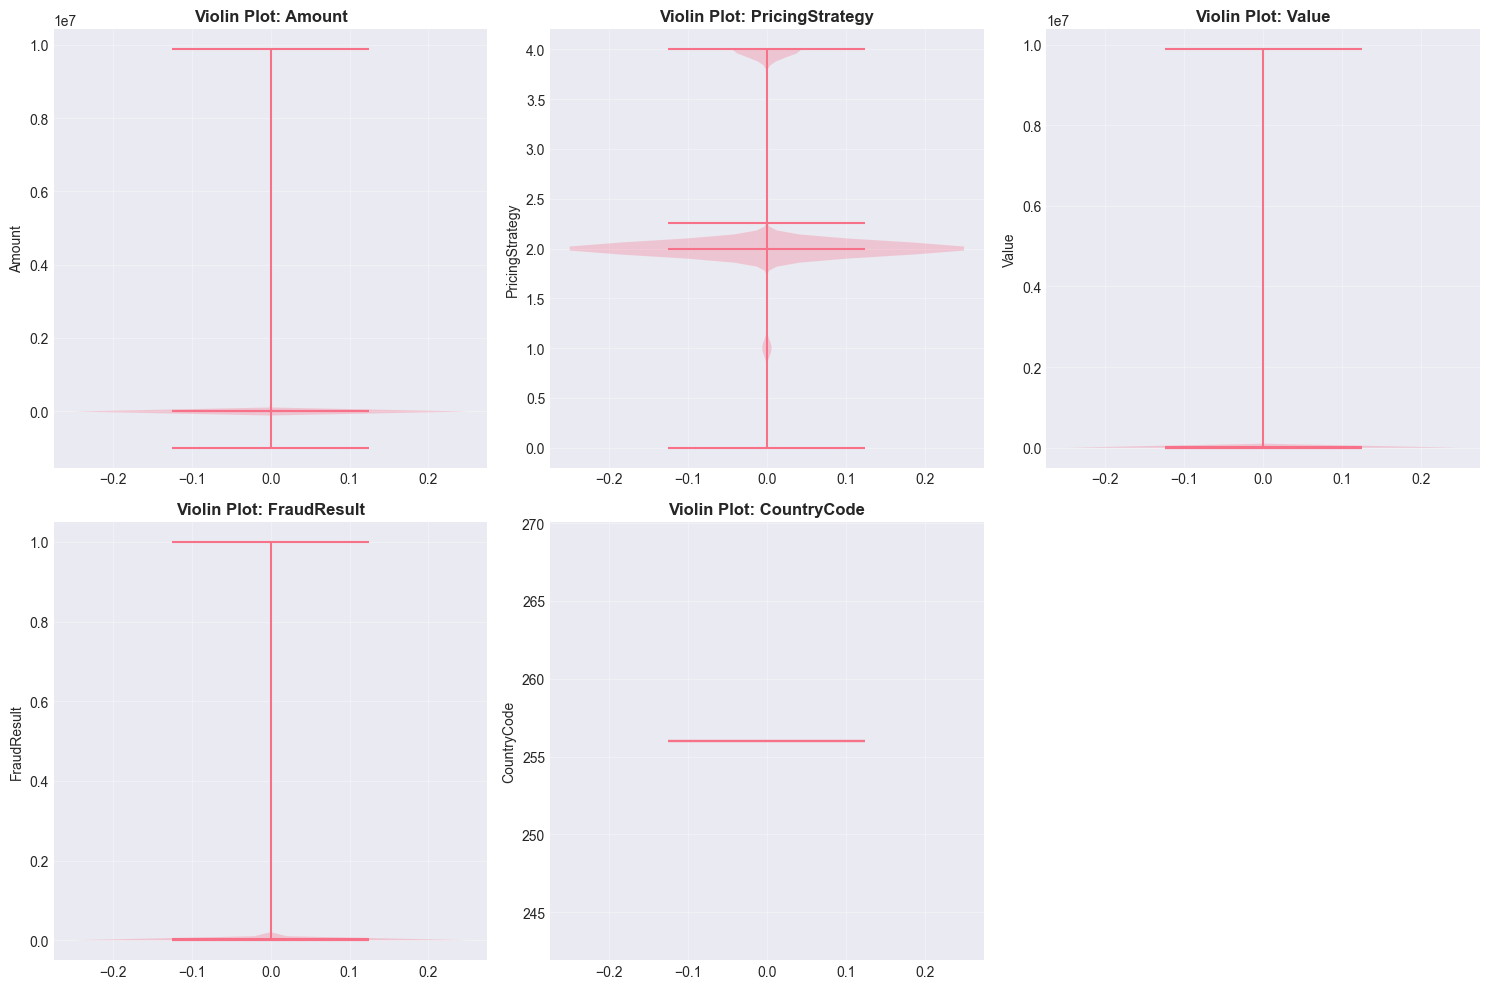

In [9]:
if not df.empty and 'numerical_cols' in locals() and numerical_cols:
    print("=" * 80)
    print("OUTLIER DETECTION USING IQR METHOD")
    print("=" * 80)
    
    outlier_summary = []
    
    for col in numerical_cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
        outlier_count = len(outliers)
        outlier_percentage = (outlier_count / len(df)) * 100
        
        outlier_summary.append({
            'Column': col,
            'Lower Bound': lower_bound,
            'Upper Bound': upper_bound,
            'Outlier Count': outlier_count,
            'Outlier Percentage': outlier_percentage
        })
    
    outlier_df = pd.DataFrame(outlier_summary)
    display(outlier_df.sort_values('Outlier Percentage', ascending=False))
    
    # Visualize outliers using violin plots
    print("\n" + "=" * 80)
    print("VIOLIN PLOTS FOR OUTLIER VISUALIZATION")
    print("=" * 80)
    
    # Select top 6 numerical features with most outliers for visualization
    top_outlier_cols = outlier_df.nlargest(6, 'Outlier Percentage')['Column'].tolist()
    
    if top_outlier_cols:
        n_cols = min(3, len(top_outlier_cols))
        n_rows = (len(top_outlier_cols) + n_cols - 1) // n_cols
        
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
        axes = axes.flatten() if n_rows > 1 else [axes] if n_cols == 1 else axes
        
        for idx, col in enumerate(top_outlier_cols):
            if idx < len(axes):
                ax = axes[idx]
                
                # Violin plot
                parts = ax.violinplot([df[col].dropna()], positions=[0], showmeans=True, showmedians=True)
                ax.set_title(f'Violin Plot: {col}', fontsize=12, fontweight='bold')
                ax.set_ylabel(col, fontsize=10)
                ax.grid(True, alpha=0.3)
        
        # Hide extra subplots
        for idx in range(len(top_outlier_cols), len(axes)):
            axes[idx].axis('off')
        
        plt.tight_layout()
        plt.show()
else:
    print("No numerical columns available for outlier detection.")


## 10. Time Series Analysis (if TransactionStartTime exists)


In [ ]:
if not df.empty and 'TransactionStartTime' in df.columns:
    print("=" * 80)
    print("TIME SERIES ANALYSIS")
    print("=" * 80)
    
    try:
        # Convert to datetime
        df['TransactionStartTime'] = pd.to_datetime(df['TransactionStartTime'])
        
        # Extract time features
        df['Year'] = df['TransactionStartTime'].dt.year
        df['Month'] = df['TransactionStartTime'].dt.month
        df['Day'] = df['TransactionStartTime'].dt.day
        df['DayOfWeek'] = df['TransactionStartTime'].dt.dayofweek
        df['Hour'] = df['TransactionStartTime'].dt.hour
        
        # Transaction volume over time
        daily_transactions = df.groupby(df['TransactionStartTime'].dt.date).size()
        
        plt.figure(figsize=(15, 6))
        plt.plot(daily_transactions.index, daily_transactions.values, linewidth=2)
        plt.title('Daily Transaction Volume Over Time', fontsize=14, fontweight='bold')
        plt.xlabel('Date', fontsize=12)
        plt.ylabel('Number of Transactions', fontsize=12)
        plt.grid(True, alpha=0.3)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
        
        # Transaction amount over time (if Amount column exists)
        if 'Amount' in df.columns:
            daily_amount = df.groupby(df['TransactionStartTime'].dt.date)['Amount'].sum()
            
            plt.figure(figsize=(15, 6))
            plt.plot(daily_amount.index, daily_amount.values, linewidth=2, color='green')
            plt.title('Daily Transaction Amount Over Time', fontsize=14, fontweight='bold')
            plt.xlabel('Date', fontsize=12)
            plt.ylabel('Total Amount', fontsize=12)
            plt.grid(True, alpha=0.3)
            plt.xticks(rotation=45)
            plt.tight_layout()
            plt.show()
        
        # Day of week patterns
        if 'DayOfWeek' in df.columns:
            day_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
            day_counts = df['DayOfWeek'].value_counts().sort_index()
            
            plt.figure(figsize=(10, 6))
            plt.bar(range(len(day_names)), [day_counts.get(i, 0) for i in range(7)], color='steelblue')
            plt.xticks(range(len(day_names)), day_names, rotation=45)
            plt.title('Transaction Volume by Day of Week', fontsize=14, fontweight='bold')
            plt.ylabel('Number of Transactions', fontsize=12)
            plt.grid(True, alpha=0.3, axis='y')
            plt.tight_layout()
            plt.show()
            
    except Exception as e:
        print(f"Error in time series analysis: {e}")
else:
    print("TransactionStartTime column not found or dataframe is empty.")


## 11. Key Insights and Summary

### Top 3-5 Most Important Insights

Based on the exploratory data analysis conducted above, here are the key findings:

#### Insight 1: Excellent Data Quality with No Missing Values
**Finding**: The dataset contains 95,662 transactions across 16 features with **zero missing values**. All columns are complete, which is exceptional for real-world financial data. The data spans 90 days (November 15, 2018 to February 13, 2019) with an average of 1,051 transactions per day.

**Implication**: No imputation strategy is needed, which simplifies preprocessing. However, we should still validate data quality through business rules (e.g., negative amounts for credits, positive for debits). The clean dataset allows us to focus on feature engineering and model development without data cleaning overhead.

---

#### Insight 2: High Correlation Between Amount and Value Features
**Finding**: The `Amount` and `Value` features show an extremely high correlation of **0.99**, indicating they are essentially the same variable (Value is the absolute value of Amount). Additionally, both features show severe right-skewness (skewness > 51) with significant outliers - 25.5% of Amount values and 9.4% of Value values are outliers using the IQR method.

**Implication**: We should **drop one of these features** (likely keep `Amount` as it contains directional information - positive for debits, negative for credits) to avoid multicollinearity. The extreme skewness and outliers suggest we need robust scaling (e.g., log transformation, robust scaler) or outlier treatment (winsorization, capping) before modeling. The wide range (-1,000,000 to 9,880,000) indicates we may need to handle extreme transactions separately.

---

#### Insight 3: Highly Imbalanced Fraud and Skewed Transaction Patterns
**Finding**: Fraud is extremely rare - only **0.2% of transactions** (193 out of 95,662) are flagged as fraudulent. The transaction distribution is heavily skewed toward two product categories: **financial_services (47.46%)** and **airtime (47.07%)**, with other categories representing less than 2% each. ChannelId_3 dominates with 59.5% of transactions.

**Implication**: For fraud-based proxy variables, we'll need to handle severe class imbalance (SMOTE, class weights, or anomaly detection approaches). The concentration in two product categories suggests we should create product category features (e.g., financial_services_ratio, airtime_ratio) at the customer level. The channel distribution indicates most customers use a specific channel, which could be a behavioral signal for credit risk.

---

#### Insight 4: Significant Outliers in Transaction Amounts Require Careful Handling
**Finding**: Using the IQR method, **25.5% of Amount values are outliers** (24,441 transactions), with extreme values ranging from -1,000,000 to 9,880,000. The distribution shows extreme right-skewness (skewness = 51.1) and high kurtosis (3,363), indicating a heavy-tailed distribution with many extreme values.

**Implication**: These outliers are likely legitimate high-value transactions rather than errors, so we should **avoid removing them**. Instead, we should use robust statistical methods: (1) Winsorization at the 1st and 99th percentiles, (2) Log transformation (after handling negatives), (3) Robust scaling (using median and IQR), or (4) Create categorical features (e.g., transaction_size_category: small/medium/large/very_large). For RFM features, we should use median-based aggregations which are more robust to outliers than means.

---

#### Insight 5: Temporal Patterns Show Consistent Daily Activity with Some Variability
**Finding**: The data spans exactly **90 days** with daily transaction volumes ranging from 373 to 2,984 transactions (mean: 1,051, median: 926, std: 610). This represents approximately 3 months of transaction history, providing sufficient data for RFM feature engineering and temporal pattern analysis.

**Implication**: We should engineer temporal features at the customer level: (1) **Recency**: Days since last transaction, (2) **Frequency**: Transactions per week/month, (3) **Consistency**: Coefficient of variation in daily transaction counts, (4) **Day-of-week patterns**: Which days customers typically transact, (5) **Time-of-day patterns**: Hour of day preferences. The 90-day window is ideal for creating stable customer-level aggregations. We should also consider creating features that capture transaction velocity (transactions per day) and recency decay (weighted by time).

---

### Next Steps for Feature Engineering

Based on these insights, the following feature engineering steps are recommended:

1. **RFM Feature Engineering**: Create Recency (days since last transaction), Frequency (transaction count, transactions per week), and Monetary (total amount, median amount, amount variability) features aggregated at the customer level using robust statistics (median, IQR) to handle outliers.

2. **Handling Missing Values**: No imputation needed - data is complete. However, validate business rules (e.g., negative amounts should be credits).

3. **Outlier Treatment**: Apply winsorization at 1st and 99th percentiles for Amount/Value, or use log transformation after handling negative values. Consider creating transaction size categories (quartiles or business-defined thresholds).

4. **Categorical Encoding**: Use target encoding or frequency encoding for high-cardinality categoricals (ProductId, ProviderId). One-hot encode low-cardinality features (ProductCategory, ChannelId). Create customer-level aggregations (e.g., most_used_channel, favorite_product_category_ratio).

5. **Temporal Features**: Extract day-of-week, hour-of-day, and create customer-level temporal patterns (preferred_transaction_days, transaction_time_consistency). Calculate transaction velocity and recency-weighted features.

6. **Proxy Variable Definition**: Design proxy for credit risk using:
   - **Fraud-based signal**: Customers with fraud history or high fraud rate
   - **Transaction behavior**: Irregular patterns, sudden changes in spending
   - **Payment patterns**: Ratio of credits to debits, negative balance frequency
   - **Engagement decay**: Decreasing transaction frequency over time
   - **Risk indicators**: High-value transactions, unusual product mix

7. **Feature Selection**: Remove `Value` column (redundant with `Amount`). Consider creating interaction features between Amount, ProductCategory, and ChannelId.

8. **Data Transformation**: Apply robust scaling or quantile transformation to handle skewness. Consider power transformations (Box-Cox, Yeo-Johnson) for Amount feature.


In [10]:
# Save a summary of key statistics for reference
if not df.empty:
    summary_stats = {
        'total_rows': len(df),
        'total_columns': len(df.columns),
        'numerical_features': len(numerical_cols) if 'numerical_cols' in locals() else 0,
        'categorical_features': len(categorical_cols) if 'categorical_cols' in locals() else 0,
        'missing_values_total': df.isnull().sum().sum(),
        'duplicate_rows': df.duplicated().sum()
    }
    
    print("=" * 80)
    print("EDA SUMMARY STATISTICS")
    print("=" * 80)
    for key, value in summary_stats.items():
        print(f"{key.replace('_', ' ').title()}: {value:,}")
    
    print("\nEDA completed successfully!")


EDA SUMMARY STATISTICS
Total Rows: 95,662
Total Columns: 16
Numerical Features: 5
Categorical Features: 11
Missing Values Total: 0
Duplicate Rows: 0

EDA completed successfully!
